# Diabetes Prediction Project

This project aims to predict the presence of diabetes using various health indicators. The data is retrieved from a SQL Server database, and machine learning techniques are applied to create a prediction model.

## Tools and Libraries

The following tools and libraries are used in this project:

- **pypyodbc**: For connecting to the SQL Server database.
- **pandas**: For data manipulation and analysis.
- **numpy**: For numerical operations.
- **seaborn**: For data visualization.
- **scikit-learn**: For machine learning algorithms and model evaluation.
- **matplotlib**: For plotting graphs.

In [72]:
import pypyodbc as odbc
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
import matplotlib.pyplot as plt

## Connection to SQL Server
Establishing connection to SQL server, from which we will retrieve data.

In [73]:
DRIVER_NAME = "SQL Server"
SERVER_NAME = "DESKTOP-PJBN9BQ\\SQLEXPRESS"
DATABASE_NAME = "Diabetes"

CONNECTION_STRING = f"""
    DRIVER={{{DRIVER_NAME}}};
    SERVER={SERVER_NAME};
    DATABASE={DATABASE_NAME};
    Trust_Connection=yes;
"""

Conn = odbc.connect(CONNECTION_STRING)

Creating cursor and chosing declaring table names

In [74]:
cursor = Conn.cursor()

table_name_balanced = "diabetes_binary_split_health_indicators_BRFSS2015"
talbe_name_not_balanced = "diabetes_data_not_balanced"

# Columns to be extraced from SQL server
chosen = '"Diabetes_binary","HighBP","HighChol","BMI","Smoker","Stroke","HeartDiseaseorAttack","PhysActivity","HvyAlcoholConsump","GenHlth","DiffWalk","Sex","Age","Education","Income"'

Creating Dataframe out of table.

In [75]:
# Function that creates Dataframe out of given table name
def Create_Dataframe(table_name):
    # SQL query expression 
    query = "SELECT {} FROM {}".format(chosen, table_name) 

    # Creating and featching all the data from given tables
    cursor.execute(query)
    columns = [column[0] for column in cursor.description]
    columns[0] = "diabetes"

    # fetching all data from database
    table = cursor.fetchall()

    # Casting tables to dataframes
    dataframe = pd.DataFrame(table, columns= columns)
    
    # Changing type of data in tables to float
    for column in columns:
        dataframe[str(column)] = dataframe[str(column)].astype(float)
    
    return dataframe

## Dataset information
getting information about our chosen dataset

In [83]:
dataframe = Create_Dataframe(table_name= table_name_balanced)
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   diabetes              70692 non-null  float64
 1   highbp                70692 non-null  float64
 2   highchol              70692 non-null  float64
 3   bmi                   70692 non-null  float64
 4   smoker                70692 non-null  float64
 5   stroke                70692 non-null  float64
 6   heartdiseaseorattack  70692 non-null  float64
 7   physactivity          70692 non-null  float64
 8   hvyalcoholconsump     70692 non-null  float64
 9   genhlth               70692 non-null  float64
 10  diffwalk              70692 non-null  float64
 11  sex                   70692 non-null  float64
 12  age                   70692 non-null  float64
 13  education             70692 non-null  float64
 14  income                70692 non-null  float64
dtypes: float64(15)
memo

## Visualisation of data

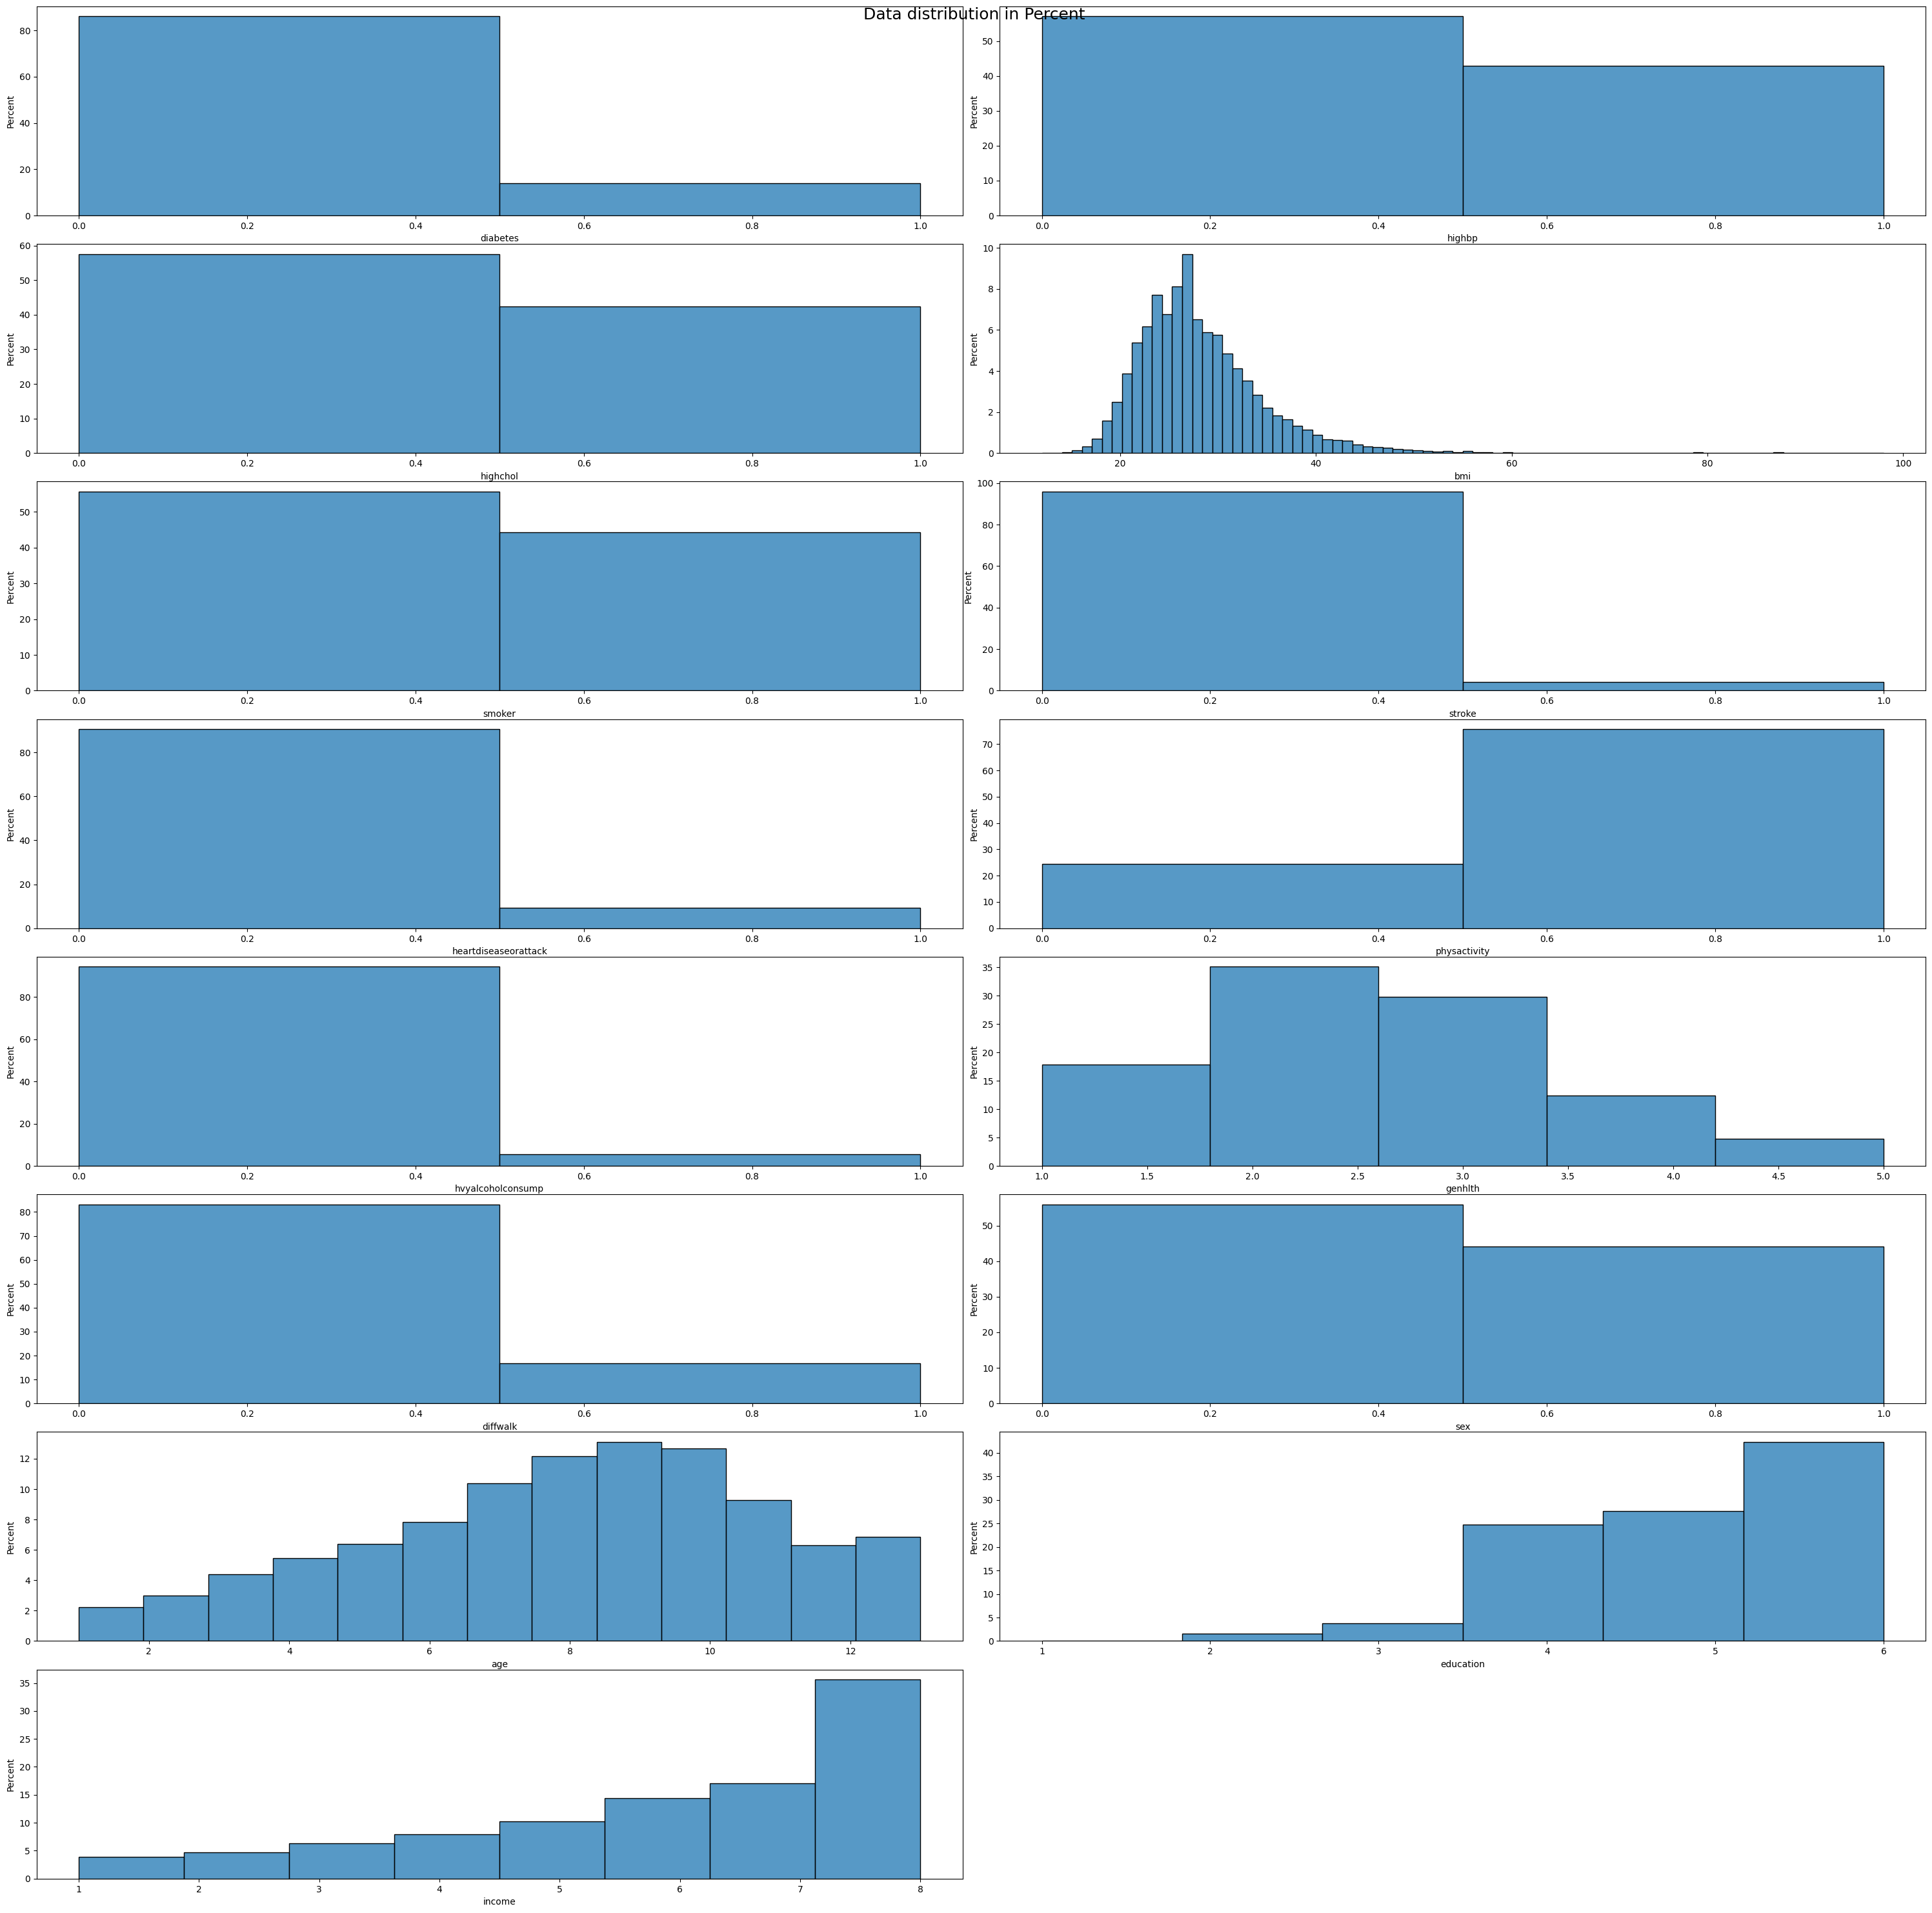

In [77]:
def Data_Distribution(dataframe):
    columns = dataframe.columns
    fig, axs = plt.subplots(len(columns)// 2 + len(columns) % 2,2, figsize = (30,30))
    fig.suptitle('Data distribution in Percent', fontsize=18)
    fig.tight_layout()
    index = 0
    axs = axs.flatten()
    for i in range(0, len(axs)):
        if (index < len(columns)):
            # Cosmetic
            min_value = dataframe[str(columns[index])].min()
            max_value = dataframe[str(columns[index])].max()
            width_value = max_value - min_value
            bins_amount =  len(set(dataframe[str(columns[index])]))
            bin_width = width_value/ bins_amount
            
            sns.histplot(data = dataframe[str(columns[index])], ax = axs[i] ,multiple="stack", stat = "percent", bins = bins_amount, binwidth= bin_width)
            axs[i].set_xlabel(str(columns[index]))
        else:
            axs[i].remove()
        index += 1
dataframe = Create_Dataframe(table_name= talbe_name_not_balanced)
Data_Distribution(dataframe = dataframe)


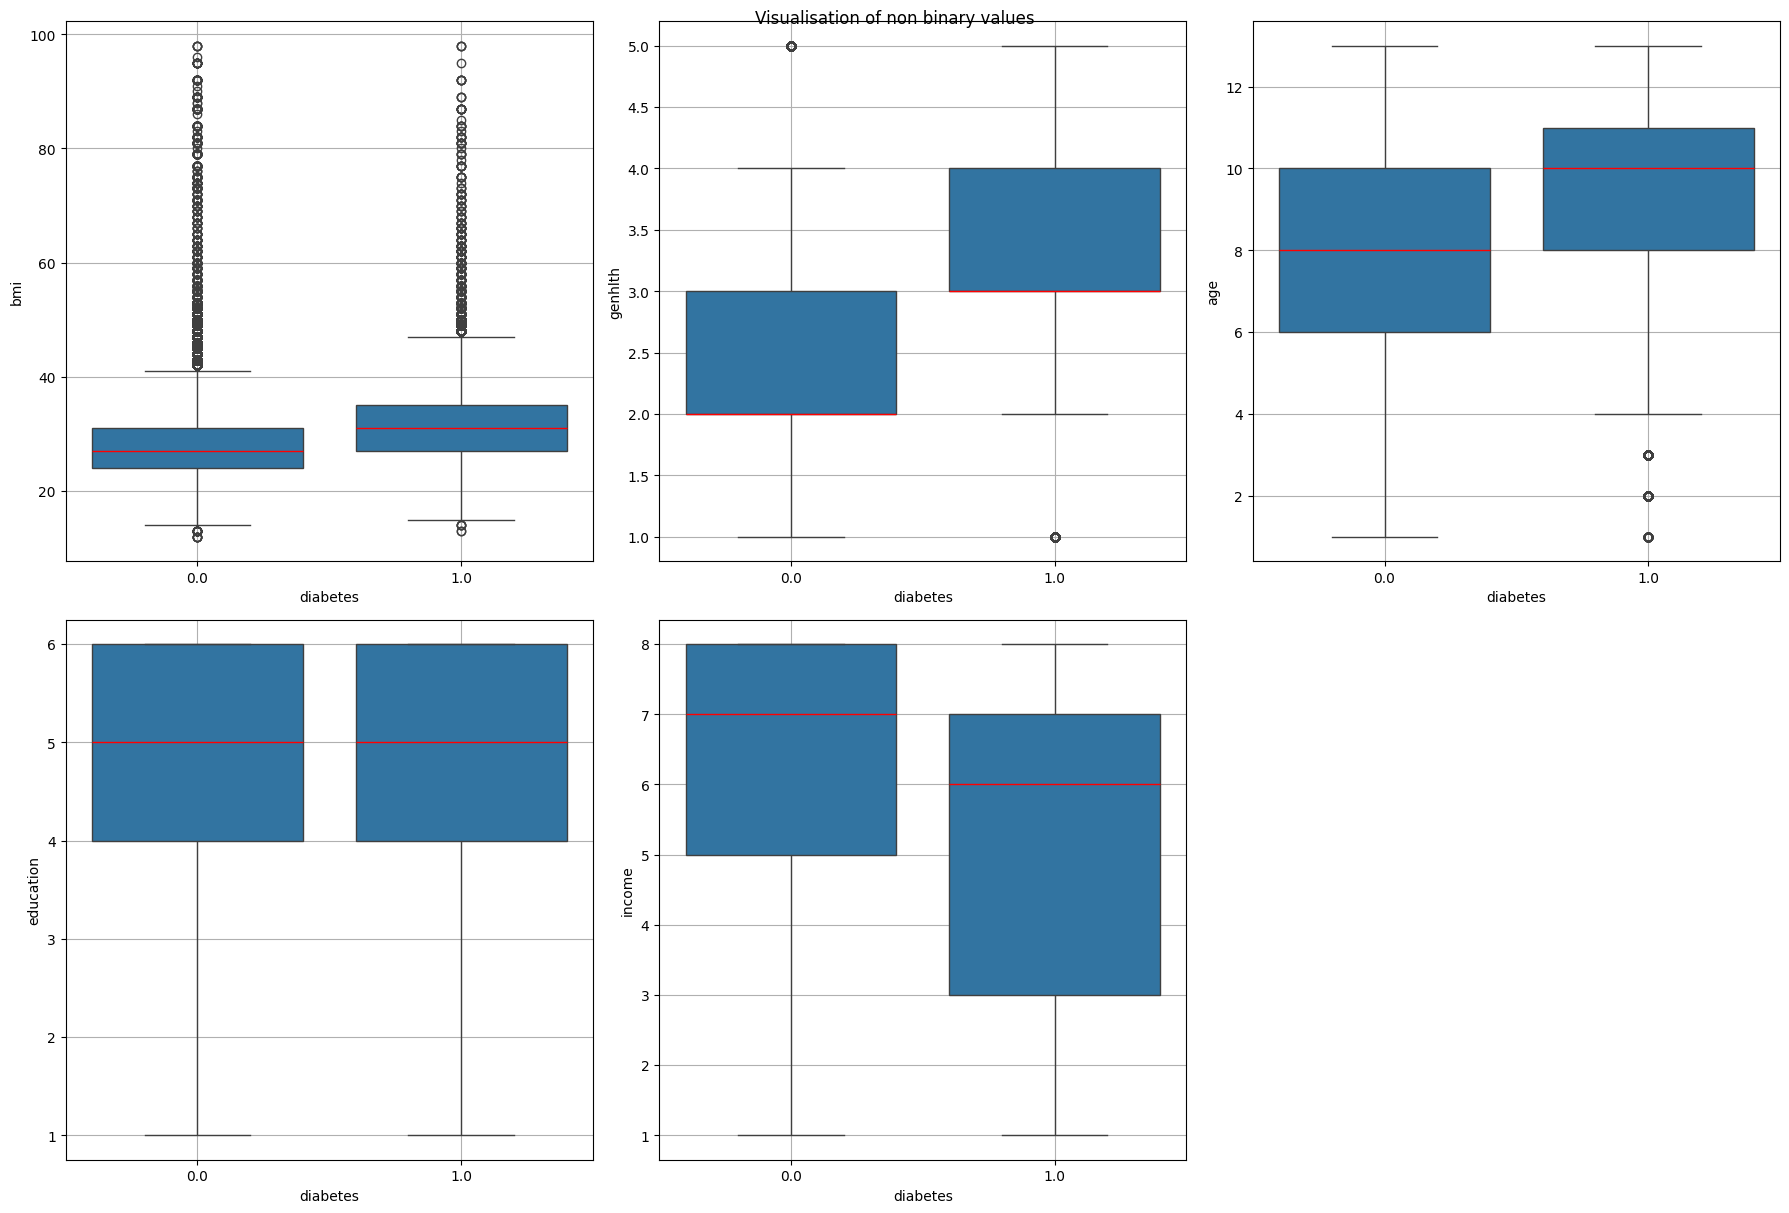

In [78]:
non_binary_columns = [column for column in dataframe.columns if dataframe[column].nunique() > 2 and column != "diabetes"]

def Non_Binary_Visualisation(dataframe):
    fig, axs = plt.subplots(len(non_binary_columns) // 3 + len(non_binary_columns)% 3, 3, figsize = (18,18))
    axs = axs.flatten()
    
    index = 0
    for i in range(0,len(axs)):
        if (index < len(non_binary_columns)):
            sns.boxplot(y = dataframe[str(non_binary_columns[index])],x = dataframe["diabetes"] ,ax=axs[i], medianprops = {"color": "r"})
            axs[i].grid()
        else:
            axs[i].remove()
        index += 1
    fig.suptitle("Visualisation of non binary values")        
    fig.tight_layout()
Non_Binary_Visualisation(dataframe)

Text(0.5, 1.0, 'Heatmap of correlations')

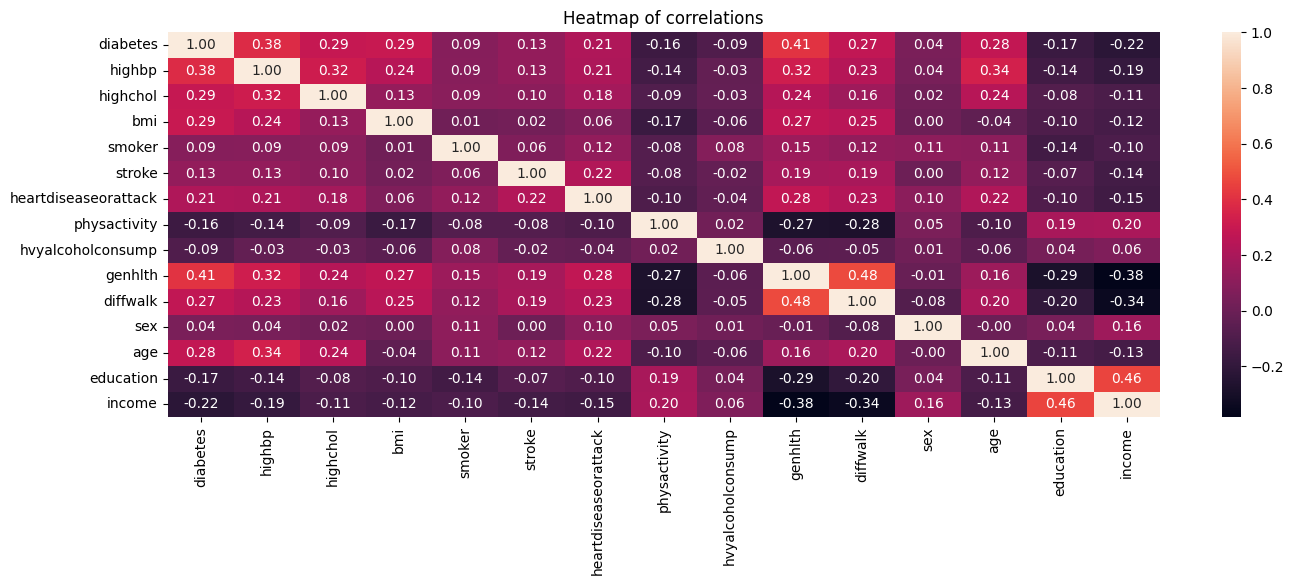

In [79]:
dataframe = Create_Dataframe(table_name= table_name_balanced)
#correlation visualisation
table_dataframe_size = dataframe.size

f, axs = plt.subplots(figsize = [16,5])
correlation = dataframe.corr()
sns.heatmap(correlation, annot= True,fmt= "0.2f" ,ax = axs)
axs.set_title("Heatmap of correlations")

## Training model to predict diabetes

In [80]:
# Training model to predict diabetes
columns = dataframe.columns

columns_without_first = columns[1:]
Y = dataframe["diabetes"].values
X = dataframe[columns_without_first].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 20)


model = Perceptron(max_iter= 15, tol = None, shuffle= True)
model.fit(X_train, Y_train)


Perceptron(max_iter=15, tol=None)

In [81]:
# Function that shows us how correct is our model
def Check_Correctness(table_name):
    dataframe = Create_Dataframe(table_name)
    columns = dataframe.columns
    columns_without_first = columns[1:]
    Y = dataframe["diabetes"].values
    X = dataframe[columns_without_first].values
    
    print(f"score of model: {model.score(X, Y)}")
    dataframe["predicted_value"] = model.predict(dataframe[columns_without_first].values)

    correct = 0; incorrect = 0
    for i in range(len(dataframe)):
        if (float(dataframe["diabetes"].iloc[i]) == float(dataframe["predicted_value"].iloc[i])):
            correct += 1
        else:
            incorrect += 1
            
            
    print(f"amount of correct predictions: {correct}")
    print(f"amount of INcorrect predictions: {incorrect}")


checking how correct is our model

In [82]:
print("Balanced data")
Check_Correctness(table_name= table_name_balanced)

print("\nNot balanced data")
Check_Correctness(talbe_name_not_balanced)

Balanced data
score of model: 0.7338029762915181
amount of correct predictions: 51874
amount of INcorrect predictions: 18818

Not balanced data
score of model: 0.7734547461368654
amount of correct predictions: 196210
amount of INcorrect predictions: 57470
